In [6]:
import torch

from model import GradKNN
from configs.config import config

print(config["sklearn_seed"])

42


In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
from utils.other import GradKNNDataloader

data_loader = GradKNNDataloader(num_tasks=6, dataset_name="tinyimagenet", load_covariances=True, load_prototypes=False)
model = GradKNN(config, device=device)

accuracy = []

for i in range(6):
    X_train, y_train, X_test, y_test, covariances, prototypes = data_loader.get_data(i)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    acc = (torch.sum((y_test.flatten().to(device) == predictions).int()) / X_test.shape[0] * 100).item()
    print(f"Accuracy: {acc} MY")

    accuracy.append(acc)

print(accuracy)
print(sum(accuracy)/len(accuracy))

Warning!!! All values smaller than 0 were set to 0, bacuse tukey transformation can't handle negative values!
Accuracy: 68.41999816894531 MY
Warning!!! All values smaller than 0 were set to 0, bacuse tukey transformation can't handle negative values!
Accuracy: 62.54999542236328 MY
Warning!!! All values smaller than 0 were set to 0, bacuse tukey transformation can't handle negative values!
Accuracy: 60.70000076293945 MY
Warning!!! All values smaller than 0 were set to 0, bacuse tukey transformation can't handle negative values!
Accuracy: 58.10000228881836 MY
Warning!!! All values smaller than 0 were set to 0, bacuse tukey transformation can't handle negative values!
Accuracy: 55.13333511352539 MY
Warning!!! All values smaller than 0 were set to 0, bacuse tukey transformation can't handle negative values!
Accuracy: 52.48999786376953 MY
[68.41999816894531, 62.54999542236328, 60.70000076293945, 58.10000228881836, 55.13333511352539, 52.48999786376953]
59.56555493672689


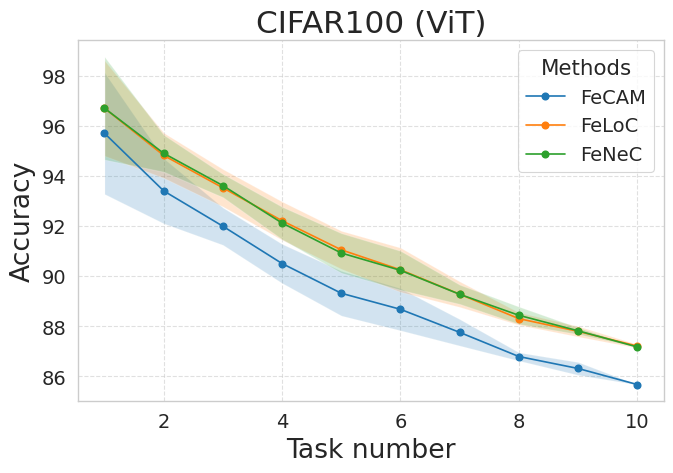

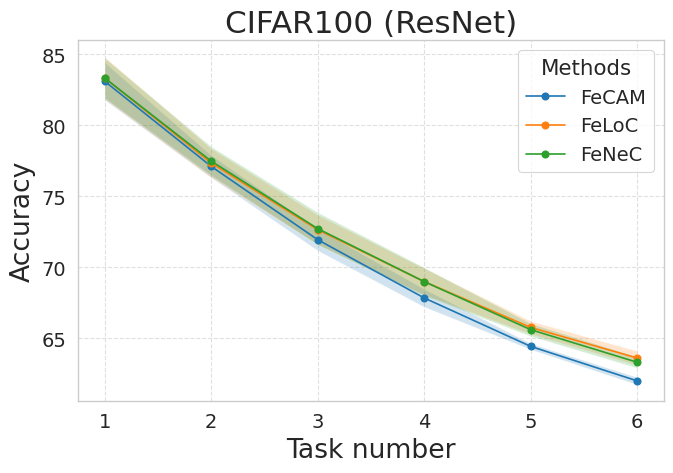

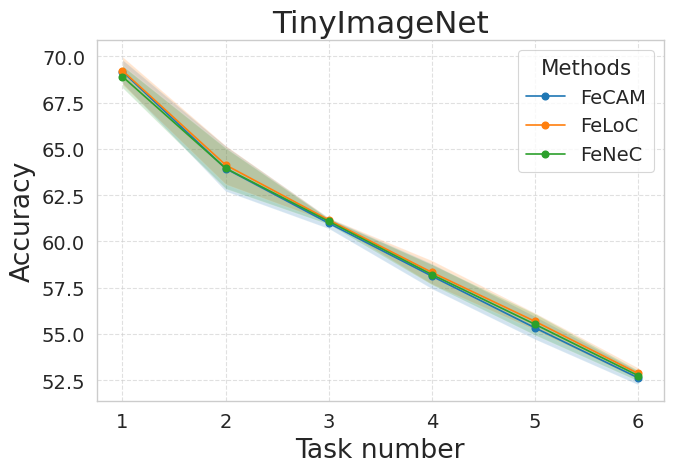

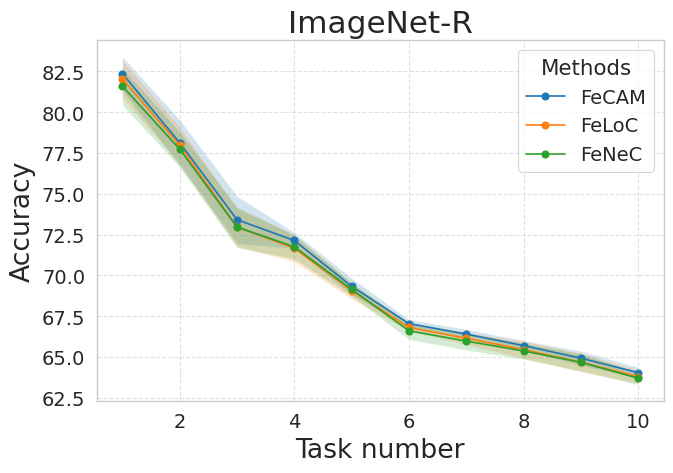

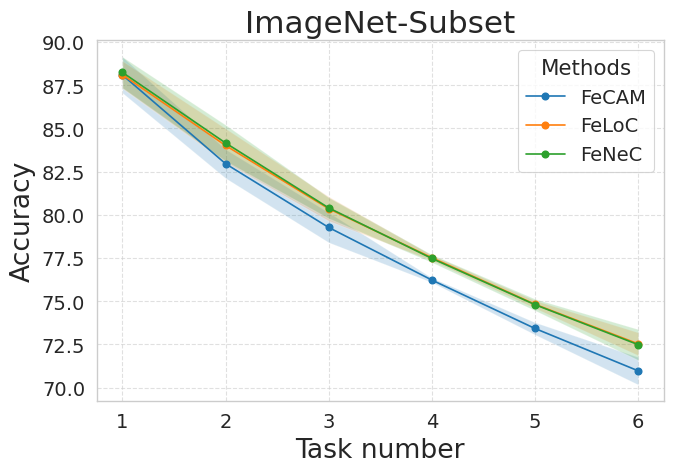

In [1]:
import pandas as pd
from utils.draw_plot import plot_method_scores

plot_method_scores(pd.read_csv("./data/charts_drawing/cifar_vit.csv"), "CIFAR100 (ViT)")
plot_method_scores(pd.read_csv("./data/charts_drawing/cifar_resnet.csv"), "CIFAR100 (ResNet)")
plot_method_scores(pd.read_csv("./data/charts_drawing/tinyimagenet.csv"), "TinyImageNet")
plot_method_scores(pd.read_csv("./data/charts_drawing/imagenet-r.csv"), "ImageNet-R")
plot_method_scores(pd.read_csv("./data/charts_drawing/imagenet-subset.csv"), "ImageNet-Subset")

In [8]:
data = pd.read_csv("hyperparameters_selection/best_parameters_results_full/imnet-subset-resnet.csv", sep=";")

line_one = ["FeNeC", data["accuracy_task_1_name1"][0].item(), data["accuracy_task_2_name1"][0].item(), data["accuracy_task_3_name1"][0].item(), data["accuracy_task_4_name1"][0].item(), data["accuracy_task_5_name1"][0].item(), data["accuracy_task_6_name1"][0].item()] #, data["accuracy_task_7_name1"][0].item(), data["accuracy_task_8_name1"][0].item(), data["accuracy_task_9_name1"][0].item(), data["accuracy_task_10_name1"][0].item()]
line_two = ["FeNeC", data["accuracy_task_1_name2"][0].item(), data["accuracy_task_2_name2"][0].item(), data["accuracy_task_3_name2"][0].item(), data["accuracy_task_4_name2"][0].item(), data["accuracy_task_5_name2"][0].item(), data["accuracy_task_6_name2"][0].item()] #, data["accuracy_task_7_name2"][0].item(), data["accuracy_task_8_name2"][0].item(), data["accuracy_task_9_name2"][0].item(), data["accuracy_task_10_name2"][0].item()]
line_three = ["FeNeC", data["accuracy_task_1_name3"][0].item(), data["accuracy_task_2_name3"][0].item(), data["accuracy_task_3_name3"][0].item(), data["accuracy_task_4_name3"][0].item(), data["accuracy_task_5_name3"][0].item(), data["accuracy_task_6_name3"][0].item()] #, data["accuracy_task_7_name3"][0].item(), data["accuracy_task_8_name3"][0].item(), data["accuracy_task_9_name3"][0].item(), data["accuracy_task_10_name3"][0].item()]


str1 = "FeNeC, " + str(line_one[1]) + ", " + str(line_one[2]) + ", " + str(line_one[3]) + ", " + str(line_one[4]) + ", " + str(line_one[5]) + ", " + str(line_one[6])# + ", " + str(line_one[7]) + ", " + str(line_one[8]) + ", " + str(line_one[9]) + ", " + str(line_one[10])
str2 = "FeNeC, " + str(line_two[1]) + ", " + str(line_two[2]) + ", " + str(line_two[3]) + ", " + str(line_two[4]) + ", " + str(line_two[5]) + ", " + str(line_two[6])# + ", " + str(line_two[7]) + ", " + str(line_two[8]) + ", " + str(line_two[9]) + ", " + str(line_two[10])
str3 = "FeNeC, " + str(line_three[1]) + ", " + str(line_three[2]) + ", " + str(line_three[3]) + ", " + str(line_three[4]) + ", " + str(line_three[5]) + ", " + str(line_three[6])# + ", " + str(line_three[7]) + ", " + str(line_three[8]) + ", " + str(line_three[9]) + ", " + str(line_three[10])

print(str1)
print(str2)
print(str3)

FeNeC, 87.31999969482422, 83.56666564941406, 79.85713958740234, 77.30000305175781, 74.80000305175781, 72.55999755859375
FeNeC, 88.27999877929688, 83.53333282470703, 81.05714416503906, 77.4000015258789, 74.46666717529297, 71.55999755859375
FeNeC, 89.12000274658203, 85.36666870117188, 80.28571319580078, 77.72500610351562, 75.13333892822266, 73.33999633789062


In [5]:
string = """Accuracy at 0 0.9610000252723694
Accuracy at 1 0.9235000014305115
Accuracy at 2 0.9113333225250244
Accuracy at 3 0.8977500200271606
Accuracy at 4 0.8844000101089478
Accuracy at 5 0.8808333277702332
Accuracy at 6 0.8738571405410767
Accuracy at 7 0.8690000176429749
Accuracy at 8 0.863111138343811
Accuracy at 9 0.8567000031471252"""

new_str = string.split("\n")
new_str = [(float(line.replace("Accuracy at ", "")[2:])*100) for line in new_str]
new_str = [f"{line:.16f}" for line in new_str] 

print("FeCAM, " + ", ".join(new_str))

FeCAM, 96.1000025272369385, 92.3500001430511475, 91.1333322525024414, 89.7750020027160645, 88.4400010108947754, 88.0833327770233154, 87.3857140541076660, 86.9000017642974854, 86.3111138343811035, 85.6700003147125244
